In [1]:
# Install pytorch_wavelets

!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .

fatal: destination path 'pytorch_wavelets' already exists and is not an empty directory.
/home/ssadiku/PythonProgrammingForMachineLearning/AEsVAEsGANs/pytorch_wavelets
Processing /home/ssadiku/PythonProgrammingForMachineLearning/AEsVAEsGANs/pytorch_wavelets
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54870 sha256=76622a91ee20fad06326f898ea66eed26b3fc600c6aa4878b15d7fa70204b778
  Stored in directory: /tmp/pip-ephem-wheel-cache-18t8pylw/wheels/a2/57/25/4375fe228655cc6a02db0b1466a65d5425e2c462a7024c8a7f
Successfully built pytorch-wavelets
  Attempting u

In [2]:
# Imports

import torch
import torch.utils.data 
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets, transforms 
import torchvision.models as models 
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader 

import time 
import random 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.transforms as matpl_tr
from matplotlib.ticker import FormatStrFormatter 
import matplotlib 
import math 
import sys
import csv 
import pandas as pd 
from pytorch_wavelets import DWTForward, DWTInverse 

from typing import Callable, List, Optional, Tuple, Union
Tensor = torch.Tensor

In [3]:
# Setup 

DATASET = 'CIFAR10'
b_size = 100
shuffle = False
LOAD_MODEL = False

%cd '/home/ssadiku/PythonProgrammingForMachineLearning/AEsVAEsGANs'
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print(device)

if DATASET == 'CIFAR10':
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10("Saves/Data", train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
        ]), download=True),
        batch_size=b_size, shuffle=shuffle, num_workers=2, pin_memory=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10("Saves/Data", train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ])),
        batch_size=b_size, shuffle=False, num_workers=2, pin_memory=True)

    if LOAD_MODEL:
        modelCIFAR = resnet20()
        
        if use_gpu:
            state_dict = torch.load("Saves/Models/CIFAR10ResNet110_nonorm.pt")
            modelCIFAR.load_state_dict(state_dict)
        else:
            state_dict = torch.load("Saves/Models/CIFAR10ResNet110_nonorm.pt", map_location=torch.device('cpu'))
            modelCIFAR.load_state_dict(state_dict)
        modelCIFAR.to(device)
        modelCIFAR.eval()
        
    # CIFAR10 number label to word label map
    def output_label_CIFAR10(label):
        output_mapping = {
            0: "Plane",
            1: "Car",
            2: "Bird",
            3: "Cat",
            4: "Deer",
            5: "Dog",
            6: "Frog",
            7: "Horse",
            8: "Ship",
            9: "Truck"
        }
        input = (label.item() if type(label) == torch.Tensor else label)
        return output_mapping[input]


if DATASET == 'MNIST':
    
    test_set = torchvision.datasets.MNIST("Saves/Data", 
                                         download=True,
                                         train=False,
                                         transform=transforms.Compose([transforms.ToTensor()]))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=b_size,
                                             shuffle=shuffle, drop_last=False)
    
    train_set = torchvision.datasets.MNIST("Saves/Data",
                                          download=True,
                                          train=True,
                                          transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=b_size, drop_last=False)

/home/ssadiku/PythonProgrammingForMachineLearning/AEsVAEsGANs
cuda
Files already downloaded and verified


In [6]:
# Encoder

def make_conv_layer(self, in_ch, out_ch, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU())

In [7]:
def make_deconv_layer(self, in_ch, out_ch, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU()
    )

In [10]:
# VAE CIFAR

class CIFAR10_VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim 
        
        self.encoder = nn.Sequential(
            self.make_conv_layer(3, 16, 4, 2),
            self.make_conv_layer(16, 16, 3, 1),
            self.make_conv_layer(16, 32, 4, 2),
            self.make_conv_layer(32, 32, 3, 1),
            self.make_conv_layer(32, 64, 4, 2)
        )
        
        self.decoder = nn.Sequential(
            self.make_deconv_layer(64, 32, 4, 2),
            self.make_deconv_layer(32, 32, 3, 1),
            self.make_deconv_layer(32, 16, 4, 2),
            self.make_deconv_layer(16, 16, 3, 1),
            nn.ConvTranspose(16, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )
        
        self.mean = nn.Linear(64 * 4 * 4, self.latent_dim)
        self.logvar = nn.Linear(64 * 4 * 4, self.latent_dim)
        self.lin_decoder = nn.Linear(self.latent_dim, 64 * 4 * 4)
    
    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return self.decode(z), mean, log_var

In [8]:
def encode(self, x):
    z = self.encoder(x)
    z = z.view(z.size(0), -1)
    return self.mean(z), self.logvar(z)

In [9]:
def decode(self, z):
    x = self.lin_decoder(z)
    x = x.view(x.size(0), 64, 4, 4)
    x = self.decoder(x)
    return x

In [4]:
# VAE CIFAR

class CIFAR10_VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            self.make_conv_layer(3, 16, 4, 2),
            self.make_conv_layer(16, 16, 3, 1),
            self.make_conv_layer(16, 32, 4, 2),
            self.make_conv_layer(32, 32, 3, 1),
            self.make_conv_layer(32, 64, 4, 2)
        )

        self.decoder = nn.Sequential(
            self.make_deconv_layer(64, 32, 4, 2),
            self.make_deconv_layer(32, 32, 3, 1),
            self.make_deconv_layer(32, 16, 4, 2),
            self.make_deconv_layer(16, 16, 3, 1),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.mean = nn.Linear(64 * 4 * 4, self.latent_dim)
        self.logvar = nn.Linear(64 * 4 * 4, self.latent_dim)
        self.lin_decoder = nn.Linear(self.latent_dim, 64 * 4 * 4)

    def encode(self, x):
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        return self.mean(z), self.logvar(z)

    def decode(self, z):
        x = self.lin_decoder(z)
        x = x.view(x.size(0), 64, 4, 4)
        x = self.decoder(x)
        return x

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return self.decode(z), mean, log_var

    def make_conv_layer(self, in_ch, out_ch, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU())

    def make_deconv_layer(self, in_ch, out_ch, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU())
        

class CIFAR10_VAE_LF(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            self.make_conv_layer(3, 16, 4, 2),
            self.make_conv_layer(16, 16, 3, 1),
            self.make_conv_layer(16, 32, 4, 2),
            self.make_conv_layer(32, 32, 3, 1),
            self.make_conv_layer(32, 64, 4, 2)
        )

        self.decoder = nn.Sequential(
            self.make_deconv_layer(64, 32, 4, 2),
            self.make_deconv_layer(32, 32, 3, 1),
            self.make_deconv_layer(32, 16, 4, 2),
            self.make_deconv_layer(16, 16, 3, 1),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

        self.mean = nn.Linear(64 * 2 * 2, self.latent_dim)
        self.logvar = nn.Linear(64 * 2 * 2, self.latent_dim)
        self.lin_decoder = nn.Linear(self.latent_dim, 64 * 2 * 2)

    def encode(self, x):
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        return self.mean(z), self.logvar(z)

    def decode(self, z):
        x = self.lin_decoder(z)
        x = x.view(x.size(0), 64, 2, 2)
        x = self.decoder(x)
        return x

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        return self.decode(z), mean, log_var

    def make_conv_layer(self, in_ch, out_ch, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU())

    def make_deconv_layer(self, in_ch, out_ch, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU())

Epoch: 400/400 , Batch: 481/500 , Rec. Loss: 718.2813720703125, KLD: 139.274627685546888


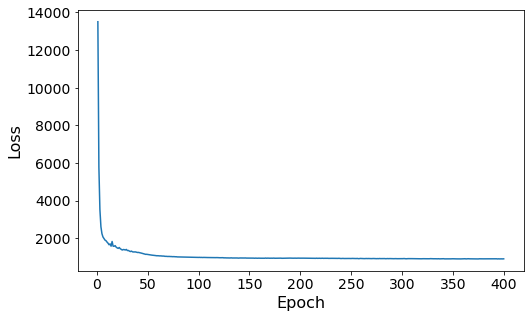

In [4]:
#@title VAE Training

def train_vae(model, train_data, epochs=20, lr=1e-3, lr_decay=0.99, logging_int=20):

    loss_fn = nn.MSELoss(reduction='sum')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    # lams[epoch] is the coefficient for the KL-divergence for the epoch
    # start with low coefficient for KL-divergence to ensure good reconstruction
    lams = torch.linspace(0.001, 1.0, epochs // 2).tolist()
    lams += [1.] * (epochs - len(lams))

    for epoch in range(epochs):
        loss_epoch = 0
        for batch_idx, (batch, label) in enumerate(train_data):
            batch = batch.to(device)
            label = label.to(device)
            bs = batch.shape[0]

            dec, mean, log_var = model(batch)
            kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var)) / bs
            rec_loss = loss_fn(dec, batch)
            loss = rec_loss + lams[epoch] * kl_div

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_decay ** (epoch + 1)

            if not batch_idx % logging_int:
                print(f'\rEpoch: {epoch+1}/{epochs} , Batch: {batch_idx+1}/{len(train_data)} , Rec. Loss: {rec_loss}, KLD: {kl_div}', end='')
        losses.append(loss_epoch / len(train_loader))
    print('')
    model.eval()
    return losses



def train_LL_vae(model, train_data, epochs=20, lr=1e-3, lr_decay=0.99, logging_int=20):

    loss_fn = nn.MSELoss(reduction='sum')
    DWT = DWTForward(J=1, wave='db4', mode='periodization').to(device)
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    # lams[epoch] is the coefficient for the KL-divergence for the epoch
    # start with low coefficient for KL-divergence to ensure good reconstruction
    lams = torch.linspace(0.001, 1.0, epochs // 2).tolist()
    lams += [1.] * (epochs - len(lams))

    for epoch in range(epochs):
        loss_epoch = 0
        for batch_idx, (batch, label) in enumerate(train_data):
            bs = batch.shape[0]
            label = label.to(device)
            batch = batch.to(device)
            batch, _ = DWT(batch)
            # map LL band to [0,1]
            max_ = batch.view(bs, -1).max(dim=1)[0][:, None, None, None]
            min_ = batch.view(bs, -1).min(dim=1)[0][:, None, None, None]
            batch = (batch - min_) / (max_ - min_)

            dec, mean, log_var = model(batch)
            dec = dec * (max_ - min_) + min_

            kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var)) / bs
            rec_loss = loss_fn(dec, batch)
            loss = rec_loss + lams[epoch] * kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_decay ** (epoch + 1)

            if not batch_idx % logging_int:
                print(f'\rEpoch: {epoch+1}/{epochs} , Batch: {batch_idx+1}/{len(train_data)} , Rec. Loss: {rec_loss}, KLD: {kl_div}', end='')
        losses.append(loss_epoch / len(train_loader))
    print('')
    model.eval()
    return losses

VAE = CIFAR10_VAE_LF()
VAE.to(device)
losses = train_LL_vae(VAE, train_loader, lr=1e-3, epochs=400)
fig, ax = plt.subplots(figsize=(8, 4.8))
plt.plot([i + 1 for i in range(len(losses))], losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()             

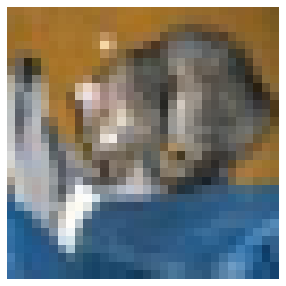

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


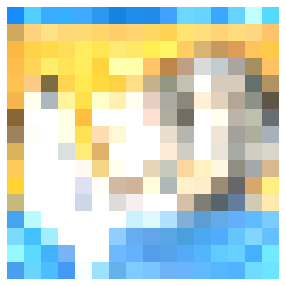

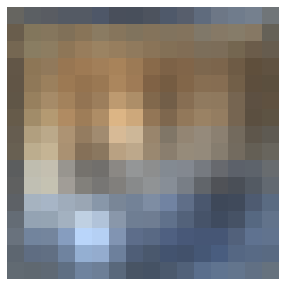

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


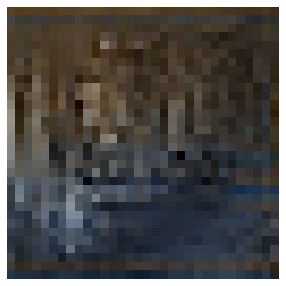

In [23]:
DWT = DWTForward(J=1, wave='db4', mode='periodization').to(device)
iDWT = DWTInverse(wave='db4', mode='periodization').to(device)

x, _ = next(iter(test_loader))
x = x.to(device)
x_l, x_h = DWT(x)

# map to [0, 1]
x_l_ = x_l
max_ = x_l.view(x.shape[0], -1).max(dim=1)[0][:, None, None, None]
min_ = x_l.view(x.shape[0], -1).min(dim=1)[0][:, None, None, None]
x_l = (x_l - min_) / (max_ - min_)

x_rec = VAE(x_l)[0]

# map back to original domain
x_rec = x_rec * (max_ - min_) + min_

x_rec_full = iDWT((x_rec, x_h))

idx = 0

fig = plt.figure(figsize=(5, 5))
plt.imshow(x[idx].detach().cpu().permute(1,2,0))
plt.axis('off')
plt.show()
fig = plt.figure(figsize=(5, 5))
plt.imshow(x_l_[idx].detach().cpu().permute(1,2,0))
plt.axis('off')
plt.show()
fig = plt.figure(figsize=(5, 5))
plt.imshow(x_rec[idx].detach().cpu().permute(1,2,0))
plt.axis('off')
plt.show()
fig = plt.figure(figsize=(5, 5))
plt.imshow(x_rec_full[idx].detach().cpu().permute(1,2,0))
plt.axis('off')
plt.show()